In [1]:
# -*- coding: utf-8 -*-   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [2]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\SimSun.ttc", size=14)

In [4]:
db = pd.read_excel(r'C:\Users\ren.x.1\Desktop\JD_Pricing\JD\JFM_HC_ePOS.xlsx',encoding='gbk')
db.shape

(25331, 20)

In [5]:
#db.dropna(inplace = True)

In [6]:
db.BrandName.value_counts()

海飞丝             6646
沙宣（VS）          6536
潘婷（pantene）     6369
飘柔（Rejoice）     4630
伊卡璐（CLAIROL）     953
袋鼠（Aussie）       141
Hair Recipe       53
吉列（Gillette）       3
Name: BrandName, dtype: int64

In [7]:
# df = db[db.BrandName == u'沙宣（VS）']
df = db.copy()

In [8]:
df.Abnormal.value_counts()

normal              24975
abnormal - back       238
abnormal - front      118
Name: Abnormal, dtype: int64

In [9]:
# exclude coupon,promotion pack, abnormal wholesale
df = df[- df.Mechanism.str.contains(u"领券")]
df = df[df.Mechanism != 'PP']
df = df[df.Abnormal == 'normal']

In [10]:
# df.Date = pd.to_datetime(df.Date)

In [68]:
# visualize PE chart
def jointplt(ProductCode,df):
    SKU = df[df['ProductCode'] == ProductCode][['Sales_Price',u'Sales_Num','uv']]
    SKU['Productivity'] = (SKU.Sales_Num/SKU.uv)
    SKU['ProductivityScale'] =  SKU['Productivity']/SKU['Productivity'].max()
    SKU['Sales_PriceScale'] = SKU['Sales_Price']/SKU['Sales_Price'].max()
    sns.jointplot(x="Sales_PriceScale", y="ProductivityScale", kind = 'reg', color = 'r', data=SKU)
    plt.ylim(0,1)
    plt.xlim(0,1)

In [75]:
# Regression in ln space, p-value and pearson correlation control
from scipy.stats.stats import pearsonr

def statsReg(ProductCode,df):
    SKU = df[df.ProductCode == ProductCode]
    x = np.log(SKU.Sales_Price)
    y = np.log(SKU.Sales_Num/SKU.uv)
    pearson = pearsonr(x,y)[0]
    #print pearson
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    if p_value < 0.05 and abs(pearson) >= 0.5:
        return np.round(slope,decimals=1)
    else:
        return 'Mark'

In [95]:
# Regression after re-scaling, p-value and pearson correlation control
from scipy.stats.stats import pearsonr

def scaleReg(ProductCode,df):
    SKU = df[df.ProductCode == ProductCode]
    x = SKU.Sales_Price/SKU.Sales_Price.max()
    productivity = SKU.Sales_Num/SKU.uv
    y = productivity/productivity.max()
    pearson = pearsonr(x,y)[0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    if p_value < 0.05 and abs(pearson) >= 0.4:
        return np.round(slope,decimals=1)
    else:
        return 'Mark'

In [96]:
PE_Hash_1 = {}
for code in df.ProductCode:
    PE_Hash_1[code] = scaleReg(code,df)

PE_DF_1 =  pd.DataFrame.from_dict(PE_Hash_1, orient='index', dtype=None)
PE_DF_1.columns = ['PE']
PE_DF_1.head()

,PE
844529,Mark
2367781,1.3
2852609,Mark
1211595,Mark
411151,-0.9


**Three-Chanel split: TPR, 199-100, others**

In [97]:
df.Mechanism.value_counts()

single TPR    5819
满159减60       4249
满199减100      2939
3件7折 4件6折     2139
满199减80       1607
满99减30        1259
赠品/国际店         483
Name: Mechanism, dtype: int64

In [98]:
# 1-TPR; 2-199-100; 3-Others
df1 = df[df.Mechanism == 'single TPR']

df2 = df[df.Mechanism == u'满199减100']

mask3 = (df.Mechanism != 'single TPR') & (df.Mechanism != u'满199减100')

df3 = df[mask3]

In [99]:
df3.Mechanism.value_counts()

满159减60      4249
3件7折 4件6折    2139
满199减80      1607
满99减30       1259
赠品/国际店        483
Name: Mechanism, dtype: int64

In [100]:
PE_1 = {}
for code in df1.ProductCode:
    PE_1[code] = scaleReg(code,df1)

PE_DF1 =  pd.DataFrame.from_dict(PE_1, orient='index')
PE_DF1.columns = ['TPR_PE']

In [101]:
PE_DF1.head()

,TPR_PE
844529,Mark
2852609,Mark
1211595,Mark
411151,-3.3
2907152,Mark


In [102]:
PE_2 = {}
for code in df2.ProductCode:
    PE_2[code] = scaleReg(code,df2)

PE_DF2 =  pd.DataFrame.from_dict(PE_2, orient='index')
PE_DF2.columns =['199-100_PE']

In [103]:
PE_DF2.head()

,199-100_PE
411151,Mark
301621,-1.2
301622,-0.7
301623,-0.9
1093694,-0.9


In [104]:
PE_DF2['199-100_PE'].value_counts()

Mark    49
-1.0    15
-1.2    14
-1.3    10
-0.9     8
-1.1     8
-0.8     7
-1.5     5
-1.4     3
-0.7     3
-1.8     2
-0.6     1
-4.2     1
Name: 199-100_PE, dtype: int64

In [105]:
PE_3 = {}
for code in df3.ProductCode:
    PE_3[code] = scaleReg(code,df3)

PE_DF3 =  pd.DataFrame.from_dict(PE_3, orient='index')
PE_DF3.columns =['Others_PE']

In [106]:
PE_DF3.head()

,Others_PE
773202,Mark
411151,-1.4
411118,Mark
845098,-1
301621,-0.7


In [107]:
# Merge different mechanisms
PE_ByMech_1 = PE_DF1.join(PE_DF2,how='outer')
PE_ByMech = PE_ByMech_1.join(PE_DF3,how='outer')

In [108]:
PE_ByMech.replace(np.nan,'NoData',inplace=True)
PE_ByMech.head()

,TPR_PE,199-100_PE,Others_PE
206626,Mark,-1.2,-0.8
206627,Mark,Mark,-0.5
206628,Mark,NoData,-0.5
206629,Mark,-0.9,-1
206631,Mark,NoData,Mark


In [109]:
output = pd.merge(df, PE_ByMech, how='left',left_on=['ProductCode'],right_index = True)
output.to_excel('JD_HC_ePOS_PE_0515.xlsx')

In [110]:
prodNames = []
for idx in PE_ByMech.index:
    prodNames.append(df[df.ProductCode == idx].ProductName.iloc[0])
PE_ByMech['productName'] = prodNames

# margin = []
# for idx in PE_ByMech.index:
#     margin.append(np.round(float(df[df.ProductCode == idx].Offtake.sum())/df[df.ProductCode == idx].Total_Cost.sum(),decimals=2) - 1)
# PE_ByMech['margin'] = margin

# averagePrice = []
# for idx in PE_ByMech.index:
#     averagePrice.append(np.round(float(df[df.ProductCode == idx].Offtake.sum())/df[df.ProductCode == idx].Sales_Num.sum(),decimals=2))
# PE_ByMech['averagePrice'] = averagePrice

# cost = []
# for idx in PE_ByMech.index:
#     cost.append(df[df.ProductCode == idx].Unit_Cost.iloc[0])
# PE_ByMech['cost'] = cost

In [111]:
PE_ByMech.head()

,TPR_PE,199-100_PE,Others_PE,productName
206626,Mark,-1.2,-0.8,【京东超市】飘柔洗发水焗油护理750ml（洗头膏 洗发露 头发护理）
206627,Mark,Mark,-0.5,【京东超市】飘柔发膜精纯焗油精华300ml(新老包装随机发货）
206628,Mark,NoData,-0.5,【京东超市】飘柔洗发水人参滋养400ml（洗发露）
206629,Mark,-0.9,-1,【京东超市】飘柔洗发水人参滋养750ml（洗头膏 洗发露）
206631,Mark,NoData,Mark,【京东超市】飘柔去屑洗发水山茶长效柔顺家庭装750ml（洗发露 家庭护理系列）


In [113]:
PE_ByMech.to_excel('JDHC_PEPerMechan_0515.xlsx')

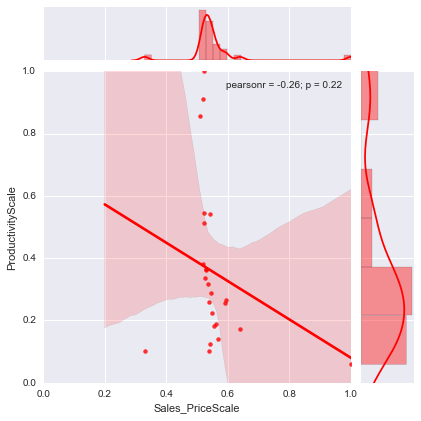

In [74]:
jointplt(206627,df2)